<a href="https://colab.research.google.com/github/mohsinposts/Machine-Learning-Collection/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
import pandas as pd
import re
import gensim
import matplotlib.pyplot as plt

In [2]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace twitter_training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace twitter_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [18]:
batch_size = 32
input_size = 100
hidden_size = 250
num_classes = 2
learning_rate = 1e-3
num_epochs = 100

In [5]:
train_df = pd.read_csv('/content/twitter_training.csv')
test_df = pd.read_csv('/content/twitter_validation.csv')

# only keep relevent columns
train_df = train_df.iloc[:, [2, -1]]
test_df = test_df.iloc[:, [2, -1]]

# rename columns
train_df.columns = ['sentiment', 'tweet']
test_df.columns = ['sentiment', 'tweet']

# replace positive and negative with 1 and 0 respectively
train_df = train_df[train_df['sentiment'].isin(['Positive', 'Negative'])].replace({'Positive': 1, 'Negative': 0})
test_df = test_df[test_df['sentiment'].isin(['Positive', 'Negative'])].replace({'Positive': 1, 'Negative': 0})

# only keep rows with strings in the tweet
train_df = train_df[train_df['tweet'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['tweet'].apply(lambda x: isinstance(x, str))]

train_df

,sentiment,tweet
0,1,I am coming to the borders and I will kill you...
1,1,im getting on borderlands and i will kill you ...
2,1,im coming on borderlands and i will murder you...
3,1,im getting on borderlands 2 and i will murder ...
4,1,im getting into borderlands and i can murder y...
...,...,...
74676,1,Just realized that the Windows partition of my...
74677,1,Just realized that my Mac window partition is ...
74678,1,Just realized the windows partition of my Mac ...
74679,1,Just realized between the windows partition of...


In [6]:
# Check if data is balanced
train_df['sentiment'].value_counts()

0    22358
1    20654
Name: sentiment, dtype: int64

In [7]:
def preprocess(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'http://\S+|https://\S+', " ", tweet)
    tweet = re.sub(r' +', " ", tweet)
    return tweet.strip().lower()

# preprocess tweets
train_df['tweet'] = train_df['tweet'].apply(preprocess).dropna()
test_df['tweet'] = test_df['tweet'].apply(preprocess).dropna()

# Remove rows where the 'tweet' column is an empty string
train_df = train_df[train_df['tweet'].str.strip().astype(bool)]
test_df = test_df[test_df['tweet'].str.strip().astype(bool)]

train_df

,sentiment,tweet
0,1,i am coming to the borders and i will kill you...
1,1,im getting on borderlands and i will kill you ...
2,1,im coming on borderlands and i will murder you...
3,1,im getting on borderlands 2 and i will murder ...
4,1,im getting into borderlands and i can murder y...
...,...,...
74676,1,just realized that the windows partition of my...
74677,1,just realized that my mac window partition is ...
74678,1,just realized the windows partition of my mac ...
74679,1,just realized between the windows partition of...


In [8]:
# Tokenize the tweets
train_tokenized = train_df['tweet'].apply(lambda x: x.split())

# Train a Word2Vec model
W2V_model = gensim.models.Word2Vec(sentences=train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

In [9]:
def get_embedding(word):
    if word in W2V_model.wv:
        return torch.tensor(W2V_model.wv[word], dtype=torch.float32)
    else:
        return torch.zeros(100, dtype=torch.float32)  # Return a zero vector if the word is not in the vocabulary

def create_tweet_embeddings(df):
    tweet_embeddings = []

    for tweet in df['tweet']:
        # Split the tweet into words and get embeddings
        embeddings = [get_embedding(word) for word in tweet.split()]
        if embeddings:
            # Stack the embeddings into one tensor and compute the mean
            tweet_embedding = torch.stack(embeddings).mean(dim=0)
        else:
            # If no words in the tweet are in the vocabulary, use a zero vector
            tweet_embedding = torch.zeros(100, dtype=torch.float32)

        tweet_embeddings.append(tweet_embedding)

    # Convert the list of tensors to a single tensor
    tweet_embeddings_tensor = torch.stack(tweet_embeddings) if tweet_embeddings else torch.empty(0, 100)

    # Convert the tensor to a list of lists (each embedding as a list) for DataFrame compatibility
    embeddings_list = tweet_embeddings_tensor.tolist()

    return embeddings_list

train_df['embeddings'] = create_tweet_embeddings(train_df)
test_df['embeddings'] = create_tweet_embeddings(test_df)

train_df

<ipython-input-9-2ea84075313c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['embeddings'] = create_tweet_embeddings(train_df)


,sentiment,tweet,embeddings
0,1,i am coming to the borders and i will kill you...,"[-1.455673336982727, 0.48071131110191345, 0.17..."
1,1,im getting on borderlands and i will kill you ...,"[-1.1921939849853516, 0.24493196606636047, 0.4..."
2,1,im coming on borderlands and i will murder you...,"[-1.0292232036590576, 0.2167886197566986, 0.30..."
3,1,im getting on borderlands 2 and i will murder ...,"[-1.040396809577942, 0.14605596661567688, 0.54..."
4,1,im getting into borderlands and i can murder y...,"[-1.1236872673034668, 0.3335123360157013, 0.44..."
...,...,...,...
74676,1,just realized that the windows partition of my...,"[-0.4612485468387604, -0.007398550398647785, 0..."
74677,1,just realized that my mac window partition is ...,"[-0.5238672494888306, 0.020812761038541794, 0...."
74678,1,just realized the windows partition of my mac ...,"[-0.36158743500709534, -0.10157100856304169, 0..."
74679,1,just realized between the windows partition of...,"[-0.34585878252983093, -0.12464603781700134, 0..."


In [10]:
# Convert the 'tweet_embeddings' and 'sentiment' columns to tensors
train_embeddings = torch.tensor(list(train_df['embeddings'])).float()
train_labels = torch.tensor(train_df['sentiment'].values).long()

test_embeddings = torch.tensor(list(test_df['embeddings'])).float()
test_labels = torch.tensor(test_df['sentiment'].values).long()

# Create TensorDatasets
train_dataset = TensorDataset(train_embeddings, train_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

# Create Pytorch DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        batch_loss = loss_fn(pred, y)

        # Backpropagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            batch_loss, current = batch_loss.item(), (batch + 1) * len(X)
            print(f"Progress:[{current:>5d}/{dataset_size:>5d}]  batch loss:{batch_loss:>8f}")

        total_loss += batch_loss

    average_loss = total_loss / num_batches
    print(f"Train Error: Avg loss: {average_loss:>8f}")
    return average_loss


def test_loop(dataloader, model, loss_fn):
    model.eval()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            # Get model pred
            pred = model(X)

            # Compute loss and
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= dataset_size

    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return test_loss

In [19]:
train_losses = []
test_losses = []

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(train_loss.detach().cpu())
    test_losses.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
Progress:[   32/42907]  batch loss:0.331384
Progress:[ 3232/42907]  batch loss:0.323478
Progress:[ 6432/42907]  batch loss:0.352547
Progress:[ 9632/42907]  batch loss:0.301139
Progress:[12832/42907]  batch loss:0.420820
Progress:[16032/42907]  batch loss:0.460334
Progress:[19232/42907]  batch loss:0.335815
Progress:[22432/42907]  batch loss:0.349174
Progress:[25632/42907]  batch loss:0.447778
Progress:[28832/42907]  batch loss:0.281886
Progress:[32032/42907]  batch loss:0.362734
Progress:[35232/42907]  batch loss:0.306995
Progress:[38432/42907]  batch loss:0.451600
Progress:[41632/42907]  batch loss:0.270719
Train Error: Avg loss: 0.336707
Test Error: Accuracy: 88.8%, Avg loss: 0.271268

Epoch 2
-------------------------------
Progress:[   32/42907]  batch loss:0.322622
Progress:[ 3232/42907]  batch loss:0.610432
Progress:[ 6432/42907]  batch loss:0.322292
Progress:[ 9632/42907]  batch loss:0.288887
Progress:[12832/42907]  batch loss:0.397988
Pro

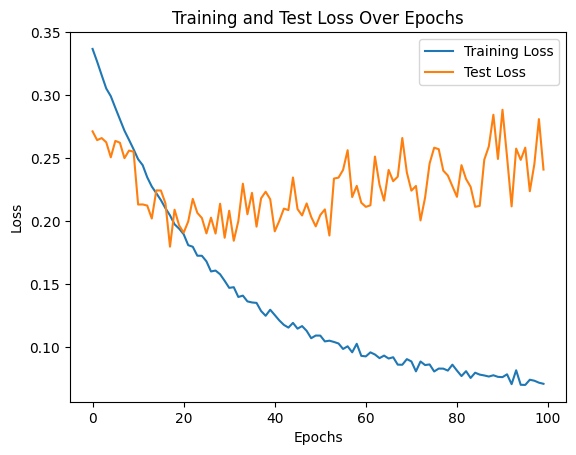

(<matplotlib.legend.Legend at 0x782d04f6ee30>, None)

In [20]:
# plot training and test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Training and Test Loss Over Epochs')
plt.legend(), plt.show()